In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils.data import DataLoader,Subset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Prepearing Data

In [11]:
# transformations
transform = T.Compose([ T.ToTensor(),
                        T.RandomHorizontalFlip(p=.5),
                        T.Normalize(.5,.5),
                       ])

# import the data and simultaneously apply the transform
trainset = datasets.FashionMNIST(root='./data', train=True,  download=True, transform=transform)
devtest  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# split the devtest into two separate sets
randidx = np.random.permutation(10000)   # a random permutation of indices
devset  = Subset(devtest,randidx[:6000]) # Subset for devset
testset = Subset(devtest,randidx[6000:]) # Subset for test

# transform to dataloaders
batchsize    = 32
train_loader = DataLoader(trainset,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(devset,  batch_size=len(devset))
test_loader  = DataLoader(testset, batch_size=len(testset))

In [12]:
# Test loading one batch of data
X, y = next(iter(train_loader))
print(f"Feature batch shape: {X.shape}")
print(f"Label batch shape: {y.shape}")

Feature batch shape: torch.Size([32, 1, 28, 28])
Label batch shape: torch.Size([32])


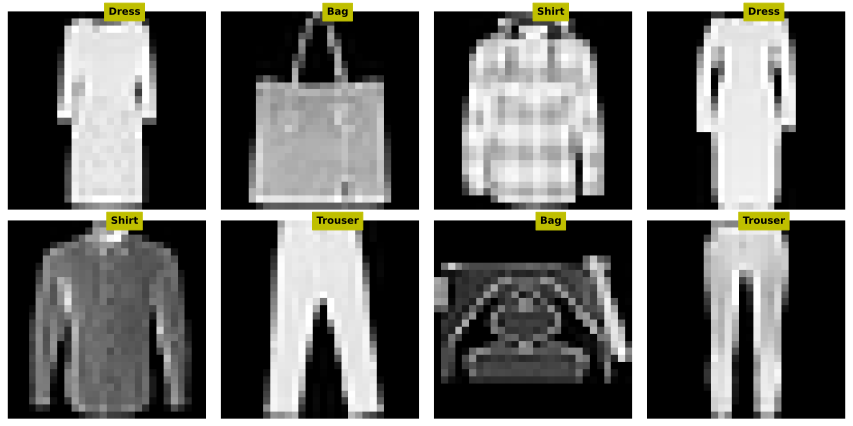

In [13]:
fig,axs = plt.subplots(2,4,figsize=(12,6))

X,y = next(iter(train_loader))

for ax in axs.flatten():
    
    randIdx = np.random.randint(0,len(X))
    pic = X.data[randIdx].numpy().reshape(28,28)
    pic = pic / 2 + 0.5
    ax.imshow(pic,cmap='gray')
    
    label = trainset.classes[y[randIdx]]

    ax.text(16, 0,label, ha='center', fontweight='bold', color='k', backgroundcolor='y')
    ax.axis('off')
    
plt.tight_layout()
plt.show()

# Creating model

In [14]:
def makeNet(printtoggle=False):
    
    class Net(nn.Module):
        def __init__(self,printtoggle):
            super().__init__()
            
            self.print = printtoggle
            
            ### ---- feature map ---- ###
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3,padding=1)
            self.bnorm1 = nn.BatchNorm2d(32)
            # output size = (28+2*1-3)/1 = 27/2 = 13 (maxpool )
            
            ### ---- feature map ---- ###
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3,padding=1)
            self.bnorm2 = nn.BatchNorm2d(64)
            # output size = (13+2*1-3)/1 = 12/2 = 6 (maxpool )
            
            ### ---- feature map ---- ###
            self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
            self.bnorm3 = nn.BatchNorm2d(128)
            # output size = (6+2*1-3)/1 = 5/2 = 2 (maxpool )
            
            ### ---- linear decision layer ---- ###
            
            self.fc1 = nn.Linear(128*2*2,512)
            self.fc2 = nn.Linear(512, 256)
            self.fc3 = nn.Linear(256, 64)
            self.fc4 = nn.Linear(64, 10)
            
        def forward(self, x):
            
            x = F.max_pool2d(self.conv1(x),2)
            x = F.leaky_relu(self.bnorm1(x))
            if self.print: print(f'First CPBR block: {list(x.shape)}')
            
            x = F.max_pool2d(self.conv2(x),2)
            x = F.leaky_relu(self.bnorm2(x))
            if self.print: print(f'Second CPBR block: {list(x.shape)}')
            
            x = F.max_pool2d(self.conv3(x),2)
            x = F.leaky_relu(self.bnorm3(x))
            if self.print: print(f'Third CPBR block: {list(x.shape)}')
            
            # reshape for linear layer
            nUnits = x.shape.numel()/x.shape[0]
            x = x.view(-1,int(nUnits))
            if self.print: print(f'Vectorized: {list(x.shape)}')
              
              # linear layers
            x = F.leaky_relu(self.fc1(x))
            x = F.dropout(x,p=.5,training=self.training)
            x = F.leaky_relu(self.fc2(x))
            x = F.dropout(x,p=.5,training=self.training)  # training=self.training means to turn off during eval mode
            x = F.leaky_relu(self.fc3(x)) 
            x = F.dropout(x,p=.5,training=self.training)
            
            x = self.fc4(x)
            if self.print: print(f'Final output: {list(x.shape)}')
        
            return x
            
    # create the model instance
    net = Net(printtoggle)
      
    # loss function
    lossfun = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.001,weight_decay=1e-5)
    
    return net,lossfun,optimizer

In [15]:
net,lossfun,optimizer = makeNet(True)

yHat = net(X)
# check size of output
print('\nOutput size:')
print(yHat.shape)

# now compute the loss
loss = lossfun(yHat,torch.squeeze(y))
print(' ')
print('Loss:')
print(loss)

First CPBR block: [32, 32, 14, 14]
Second CPBR block: [32, 64, 7, 7]
Third CPBR block: [32, 128, 2, 2]
Vectorized: [32, 512]
Final output: [32, 10]

Output size:
torch.Size([32, 10])
 
Loss:
tensor(2.2912, grad_fn=<NllLossBackward0>)


In [19]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = makeNet()

  # send the model to the GPU
  net.to(device)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  devLoss   = torch.zeros(numepochs)
  trainAcc  = torch.zeros(numepochs)
  devAcc    = torch.zeros(numepochs)


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    net.train() # switch to train mode
    batchLoss = []
    batchAcc  = []
    for X,y in train_loader:

      # push data to GPU
      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss and accuracy from this batch
      batchLoss.append(loss.item())
      batchAcc.append( torch.mean((torch.argmax(yHat,dim=1) == y).float()).item() )
    # end of batch loop...

    # and get average losses and accuracies across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    trainAcc[epochi]  = 100*np.mean(batchAcc)


    #### test performance
    net.eval() # switch to test mode
    X,y = next(iter(dev_loader))

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = net(X)
      loss = lossfun(yHat,y)

    # and get average losses and accuracies across the batches
    devLoss[epochi] = loss.item()
    devAcc[epochi]  = 100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item()

  # end epochs

  # function output
  return trainLoss,devLoss,trainAcc,devAcc,net

# Running Model

In [20]:
# ~3 minutes with 10 epochs on GPU
trainLoss,devLoss,trainAcc,devAcc,net = function2trainTheModel()

In [21]:
## the real test set!

net.eval() # switch to test mode
X,y = next(iter(test_loader))

# push data to GPU
X = X.to(device)
y = y.to(device)

# forward pass and loss
with torch.no_grad():
  yHat = net(X)
  loss = lossfun(yHat,y)

# loss and accuracy from this batch
testLoss = loss.item()
testAcc  = 100*torch.mean((torch.argmax(yHat,dim=1) == y).float()).item()

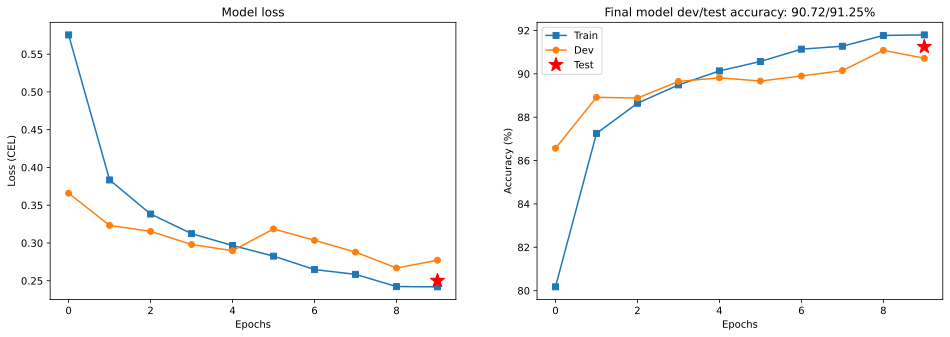

In [22]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(devLoss,'o-',label='Dev')
ax[0].plot(len(devLoss)-1,testLoss,'r*',markersize=15,label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (CEL)')
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(devAcc,'o-',label='Dev')
ax[1].plot(len(devAcc)-1,testAcc,'r*',markersize=15,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model dev/test accuracy: {devAcc[-1]:.2f}/{testAcc:.2f}%')
ax[1].legend()

plt.show()